In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Preparing data

In [2]:
df = pd.read_csv('winequality-red.csv', sep=',')
df = df.drop_duplicates()

In [16]:
# Create a new binary target: 1 if quality > 6 ("Good"), else 0 ("Not Good")
df['good_wine'] = (df['quality'] > 6).astype(int)

# Since the df has 184 1s, we are going to downsample the 0s to have a balanced dataset
good_wine_df = df[df['good_wine'] == 1].sample(n=184, random_state=42)
not_good_wine_df = df[df['good_wine'] == 0].sample(n=184, random_state=42)
balanced_df = pd.concat([good_wine_df, not_good_wine_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
print("Class Distribution:\n", y.value_counts(normalize=True))

# Drop the original 'quality' column so the model doesn't cheat
X = balanced_df.drop(['quality', 'good_wine'], axis=1)
y = balanced_df['good_wine']

Class Distribution:
 1    0.5
0    0.5
Name: good_wine, dtype: float64


# Training one  fully grown tree
To demonstrate overfitting effectively, we will train a tree without restrictions. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
tree_model = DecisionTreeClassifier(random_state=42, criterion='gini') 
tree_model.fit(X_train, y_train)

train_preds = tree_model.predict(X_train)
test_preds = tree_model.predict(X_test)

# evaluation
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"\nFully grown tree results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Actual Depth of the full tree: {tree_model.get_depth()}")

Shapes:  (294, 11) (74, 11) (294,) (74,)

Fully grown tree results:
Training Accuracy: 1.0000
Testing Accuracy:  0.7297
Actual Depth of the full tree: 11


In [22]:
first_results_balance = {
    'Dataset': ['Unbalanced', 'Balanced'],
    'Baseline' : [0.86, 0.50],
    'Tree Depth': [17, 11],
    'Training Accuracy': [1.0000, 1.0000],
    'Testing Accuracy': [0.8824, 0.7297],
    'X_train Shape': ['(1087, 11)', '(294, 11)'],
    'X_test Shape': ['(272, 11)', '(74, 11)'],
    'Gap to baseline': [0.02, 0.228]
}

first_results_balance_df = pd.DataFrame(first_results_balance)
print(first_results_balance_df.to_string(index=False))

   Dataset  Baseline  Tree Depth  Training Accuracy  Testing Accuracy X_train Shape X_test Shape  Gap to baseline
Unbalanced      0.86          17                1.0            0.8824    (1087, 11)    (272, 11)            0.020
  Balanced      0.50          11                1.0            0.7297     (294, 11)     (74, 11)            0.228


The original dataset is highly imbalanced, with 86% of wines having a quality rating below 7. To overcome the naive classifier bias (which would simply predict "Not Good" for all samples), we balance the dataset by ensuring equal representation of both classes: "Good Wine" (quality > 6) and "Not Good Wine" (quality ≤ 6).

The first results are:
Dataset  Tree Depth  Training Accuracy  Testing Accuracy X_train Shape X_test Shape  Overfitting Gap
Unbalanced          17                1.0            0.8824    (1087, 11)    (272, 11)           0.1176
Balanced          11                1.0            0.7297     (294, 11)     (74, 11)           0.2703

As expected, the model has learned **training-specific** noise rather than generalizable patterns. The tree achieves perfect **memorization** on 294 training samples but fails to generalize to unseen 74 test samples.

The 88% accuracy in the unbalanced case might seem very high but it's actually prety close of the naive baseline 86% so the bad generalisation stands. The moment we balance the dataset, the generalisation is greater even for the overfitted tree.

At first view, alcohol and sulphates are key quality indicators, yet the depth-11 structure suggests the model exploits feature interactions that may not exist in the general population.

The decreasing Gini values down the tree (0.5 → 0.37 → 0.107) indicate progressive class purity. However, this optimization occurs exclusively on training data, creating a classic bias-variance tradeoff where:

- Low bias (training accuracy = 100%)
- High variance (test accuracy drops to 73%)

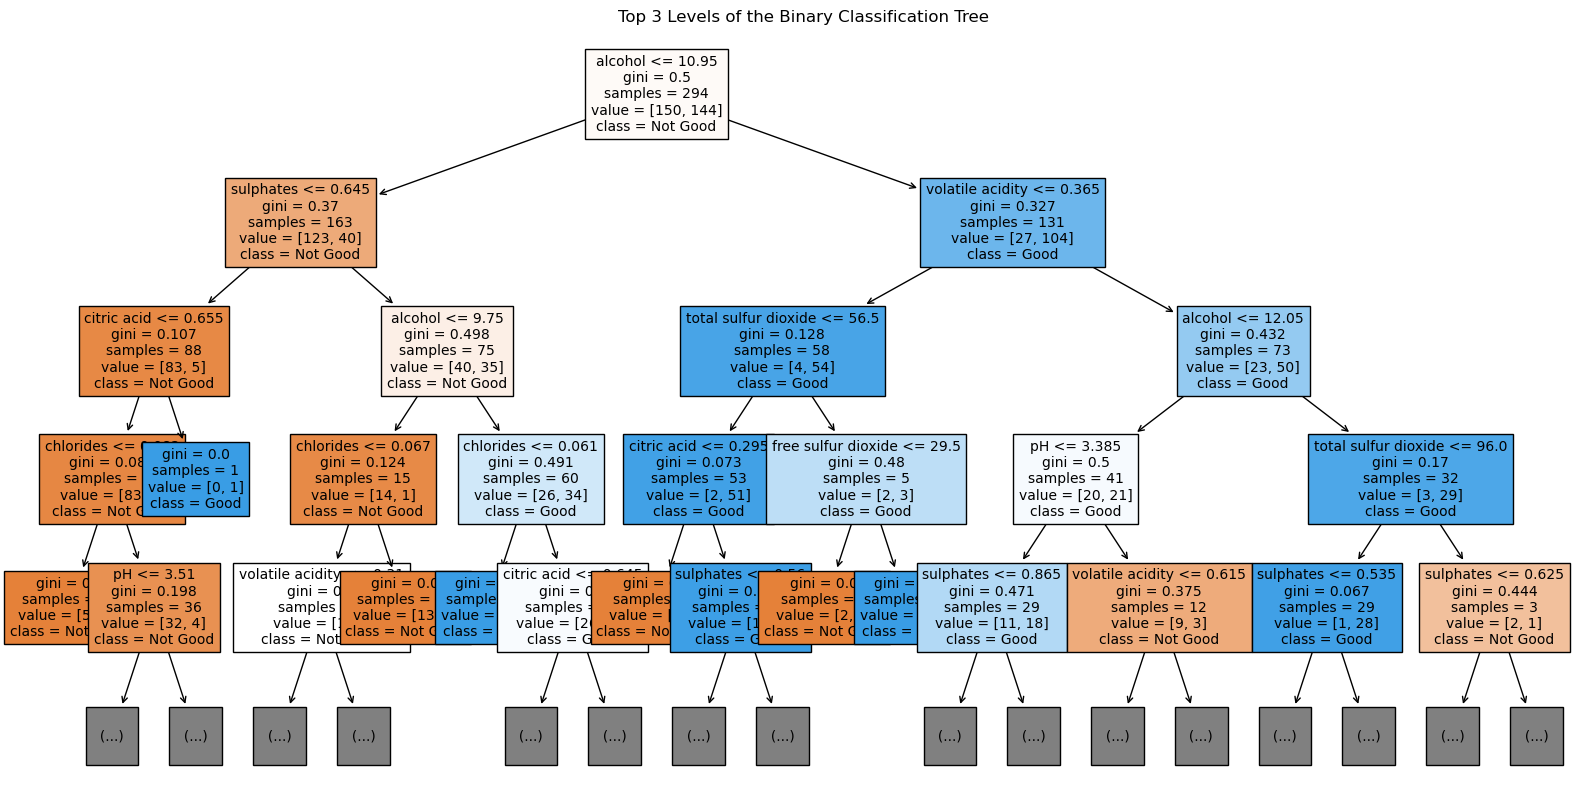

Actual Depth of the full tree: 11


In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X.columns.tolist(), 
          class_names=['Not Good', 'Good'], 
          filled=True, 
          max_depth=4,
          fontsize=10)
plt.title("Top 3 Levels of the Binary Classification Tree")
plt.show()


# Decision tree regressor

--- Single Regression Tree Results ---
Training MSE: 0.0000 (Likely 0.0 -> Perfect memorization)
Testing MSE:  0.6062 (Likely high -> High error on new data)
------------------------------
Training R2:  1.0000 (Likely 1.0)
Testing R2:   0.0723 (Likely low or negative)


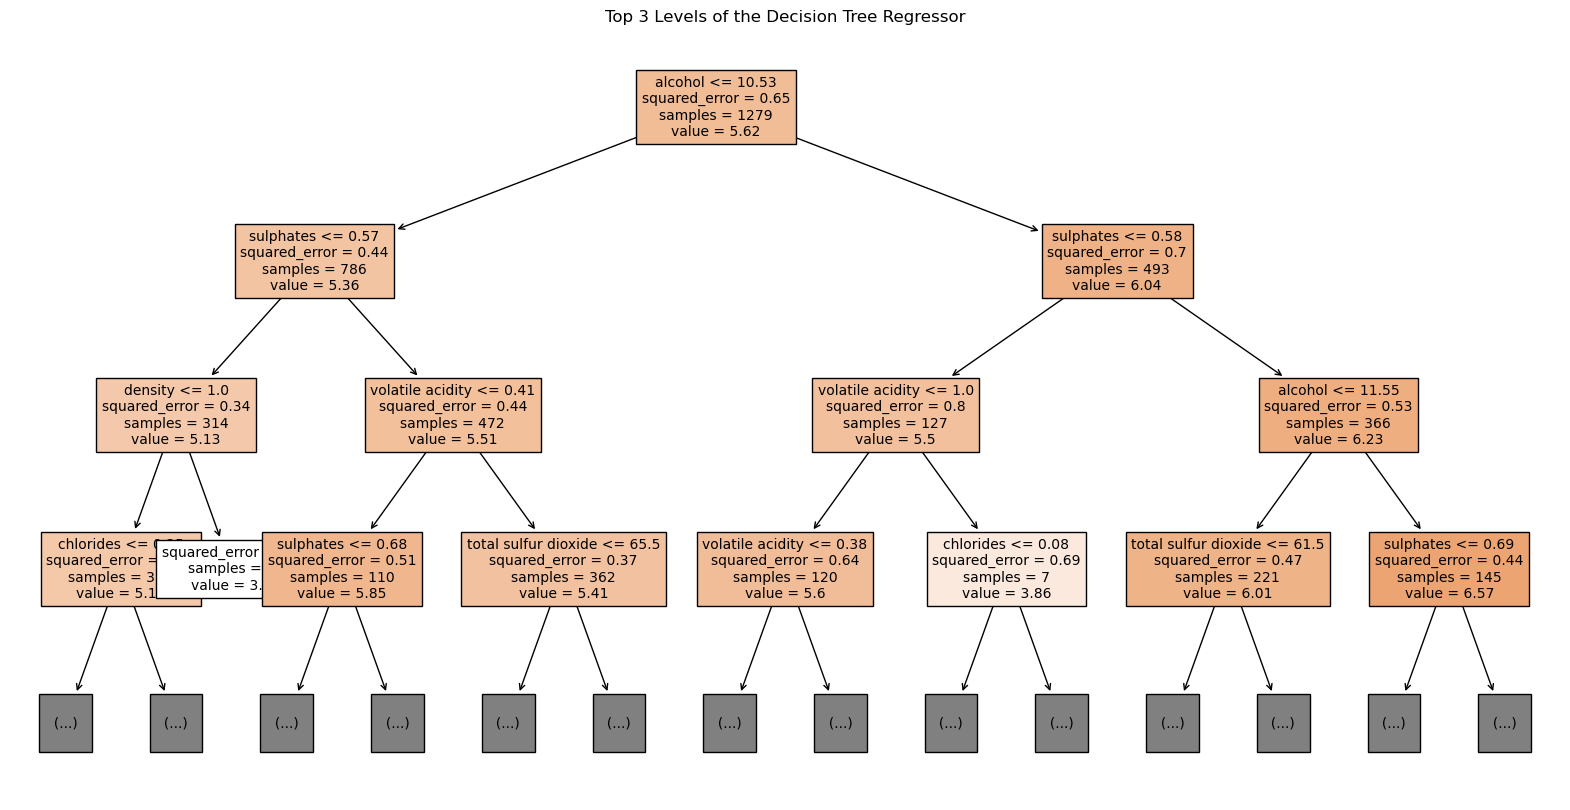

Actual Depth of the full regression tree: 25


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the dataset
df = pd.read_csv('winequality-red.csv')

# 2. Prepare Data (Regression)
# We use the original 'quality' column (scores 3 to 8) as the target
X = df.drop('quality', axis=1)
y = df['quality']

# Split into Train and Test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train a Single Decision Tree Regressor
# max_depth=None allows the tree to grow until leaves are pure (perfect predictions on train)
tree_reg = DecisionTreeRegressor(random_state=42) 
tree_reg.fit(X_train, y_train)

# 4. Evaluate Performance
# For regression, we look at MSE (lower is better) and R2 (higher is better)
train_preds = tree_reg.predict(X_train)
test_preds = tree_reg.predict(X_test)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"--- Single Regression Tree Results ---")
print(f"Training MSE: {train_mse:.4f} (Likely 0.0 -> Perfect memorization)")
print(f"Testing MSE:  {test_mse:.4f} (Likely high -> High error on new data)")
print("-" * 30)
print(f"Training R2:  {train_r2:.4f} (Likely 1.0)")
print(f"Testing R2:   {test_r2:.4f} (Likely low or negative)")

# 5. Visualize the Decisions
plt.figure(figsize=(20, 10))
plot_tree(tree_reg, 
          feature_names=X.columns.tolist(), 
          filled=True, 
          max_depth=3,  # Limiting depth for readability
          fontsize=10,
          precision=2)
plt.title("Top 3 Levels of the Decision Tree Regressor")
plt.show()

print(f"Actual Depth of the full regression tree: {tree_reg.get_depth()}")

# TODO:
- train one single tree 
- visualise the decisions of the tree
- see how it overfits and very bas in test

- trian a forest
- see how accuracy decreases but only a little but it generalises very well

- play with pruning
- play with bagging

Our objective is to proof that by choosing a random subset of features for each split, $\rho$ lowers without increasing much $\sigma^2$, achieving that the error converges to the minimum that a single tree would never achieve.